<a href="https://colab.research.google.com/github/Mouni-kalamraju/Cyclone-Tracking-using-satellite-images/blob/main/Cleaning_IBTRaCS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import struct
import os.path as path
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/ibtracs.NI.list.v04r01.csv' # Replace with your file path

try:
    df = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    print(f"Shape after loading: {df.shape}")

    # Convert 'SEASON' column to numeric, coercing errors, and then to integer
    df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce').astype('Int64')
    print("\nConverted 'SEASON' column to integer.")

    # Filter the DataFrame for BASIN = 'NI'
    df_ni = df[df['BASIN'] == 'NI']
    print("\nDataFrame filtered for BASIN = 'NI'")
    print(f"Shape after filtering BASIN: {df_ni.shape}")


    # Filter the DataFrame for SEASON between 2005 and 2024
    df_2005 = df_ni[(df_ni['SEASON'] >= 2005) & (df_ni['SEASON'] <= 2024)]
    print("\nDataFrame filtered for SEASON between 2005 and 2024")
    print(f"Shape after filtering SEASON: {df_2005.shape}")

    # Filter out rows where 'NAME' is 'UNNAMED'
    df_2005_named = df_2005[df_2005['NAME'] != 'UNNAMED']
    print("\nDataFrame filtered to remove 'UNNAMED' storms")
    print(f"Shape after removing UNNAMED: {df_2005_named.shape}")

    # Rename 'SUCS' grade to 'SCS'
    df_2005_named['NEWDELHI_GRADE'] = df_2005_named['NEWDELHI_GRADE'].replace('SUCS', 'SCS')
    print("\nRenamed 'SUCS' grade to 'SCS'")


    # Keep only the specified columns
    columns_to_keep = ['SEASON', 'SUBBASIN', 'NAME', 'ISO_TIME', 'NEWDELHI_LAT', 'NEWDELHI_LON', 'NEWDELHI_GRADE', 'NEWDELHI_WIND']
    df_2005_named = df_2005_named[columns_to_keep]
    print("\nKept specified columns")
    print(f"Shape after keeping columns: {df_2005_named.shape}")

    # Remove rows where specified columns are empty strings
    for col in ['NEWDELHI_LAT', 'NEWDELHI_LON', 'NEWDELHI_GRADE', 'NEWDELHI_WIND']:
        df_2005_named = df_2005_named[df_2005_named[col].astype(str).str.strip() != '']
    print("\nRemoved rows with empty strings in specified columns")
    print(f"Shape after removing empty strings: {df_2005_named.shape}")

    # Remove rows where 'NEWDELHI_LAT', 'NEWDELHI_LON', 'NEWDELHI_GRADE', or 'NEWDELHI_WIND' is NaN
    df_2005_named.dropna(subset=['NEWDELHI_LAT', 'NEWDELHI_LON', 'NEWDELHI_GRADE', 'NEWDELHI_WIND'], inplace=True)
    print("\nRemoved rows with missing values in specified columns")
    print(f"Shape after dropping NaNs: {df_2005_named.shape}")


    display(df_2005_named.tail())

except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

/tmp/ipython-input-2767048717.py:4: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


CSV file loaded successfully!
Shape after loading: (62049, 174)

Converted 'SEASON' column to integer.

DataFrame filtered for BASIN = 'NI'
Shape after filtering BASIN: (57169, 174)

DataFrame filtered for SEASON between 2005 and 2024
Shape after filtering SEASON: (6796, 174)

DataFrame filtered to remove 'UNNAMED' storms
Shape after removing UNNAMED: (4039, 174)

Renamed 'SUCS' grade to 'SCS'

Kept specified columns
Shape after keeping columns: (4039, 8)

Removed rows with empty strings in specified columns
Shape after removing empty strings: (3009, 8)

Removed rows with missing values in specified columns
Shape after dropping NaNs: (3009, 8)


/tmp/ipython-input-2767048717.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2005_named['NEWDELHI_GRADE'] = df_2005_named['NEWDELHI_GRADE'].replace('SUCS', 'SCS')


,SEASON,SUBBASIN,NAME,ISO_TIME,NEWDELHI_LAT,NEWDELHI_LON,NEWDELHI_GRADE,NEWDELHI_WIND
61942,2023,BB,MICHAUNG,2023-12-05 12:00:00,16.0,80.3,CS,40
61943,2023,BB,MICHAUNG,2023-12-05 15:00:00,16.4,80.4,CS,35
61944,2023,BB,MICHAUNG,2023-12-05 18:00:00,16.8,80.4,DD,30
61945,2023,BB,MICHAUNG,2023-12-05 21:00:00,17.1,80.4,DD,25
61946,2023,BB,MICHAUNG,2023-12-06 00:00:00,17.4,80.5,D,20


In [ ]:
output_path = '/content/drive/My Drive/ibtracs_cleaned.csv'

try:
    df_2005_named.to_csv(output_path, index=False)
    print(f"DataFrame saved successfully to {output_path}")
except Exception as e:
    print(f"An error occurred while saving the DataFrame: {e}")

DataFrame saved successfully to /content/drive/My Drive/ibtracs_cleaned.csv


In [ ]:
# Identify cyclones that appear in both 'AS' and 'BB' subbasins
cyclone_subbasin_counts = df_2005_named.groupby(['SEASON', 'NAME', 'SUBBASIN']).size().unstack(fill_value=0)
cyclones_in_both_subbasins = cyclone_subbasin_counts[(cyclone_subbasin_counts['AS'] > 0) & (cyclone_subbasin_counts['BB'] > 0)].index.tolist()

if not df_2005_named.empty and cyclones_in_both_subbasins:
    print("Reassigning subbasin for cyclones in both 'AS' and 'BB' based on maximum entries...")
    for season, name in cyclones_in_both_subbasins:
        # Get the rows for the current cyclone
        cyclone_data = df_2005_named[(df_2005_named['SEASON'] == season) & (df_2005_named['NAME'] == name)]

        # Count entries in each subbasin for this cyclone
        subbasin_counts = cyclone_data['SUBBASIN'].value_counts()

        # Determine the subbasin with the maximum entries
        majority_subbasin = subbasin_counts.idxmax()

        # Update the 'SUBBASIN' column for all rows of this cyclone to the majority subbasin
        df_2005_named.loc[(df_2005_named['SEASON'] == season) & (df_2005_named['NAME'] == name), 'SUBBASIN'] = majority_subbasin
        print(f"Cyclone Season: {season}, Name: {name} reassigned to subbasin: {majority_subbasin}")

    print("\nSubbasin reassignment complete.")
    # Display the updated subbasin distribution
    updated_subbasin_distribution = df_2005_named['SUBBASIN'].value_counts()
    print("Updated number of cyclones allotted to different subbasins:")
    display(updated_subbasin_distribution)

elif df_2005_named.empty:
    print("The DataFrame df_2005_named is empty, so cannot reassign subbasins.")
else:
    print("No cyclones were found in both 'AS' and 'BB' subbasins to reassign.")

Reassigning subbasin for cyclones in both 'AS' and 'BB' based on maximum entries...
Cyclone Season: 2010, Name: JAL reassigned to subbasin: BB
Cyclone Season: 2012, Name: NILAM reassigned to subbasin: BB
Cyclone Season: 2016, Name: VARDAH reassigned to subbasin: BB
Cyclone Season: 2017, Name: OCKHI reassigned to subbasin: AS
Cyclone Season: 2018, Name: DAYE reassigned to subbasin: BB
Cyclone Season: 2018, Name: GAJA reassigned to subbasin: BB
Cyclone Season: 2021, Name: GULAB:SHAHEEN-GU reassigned to subbasin: BB

Subbasin reassignment complete.
Updated number of cyclones allotted to different subbasins:


,count
SUBBASIN,
BB,1835
AS,1174


# Plot - 1: Visualize the number of cyclone entries per year.


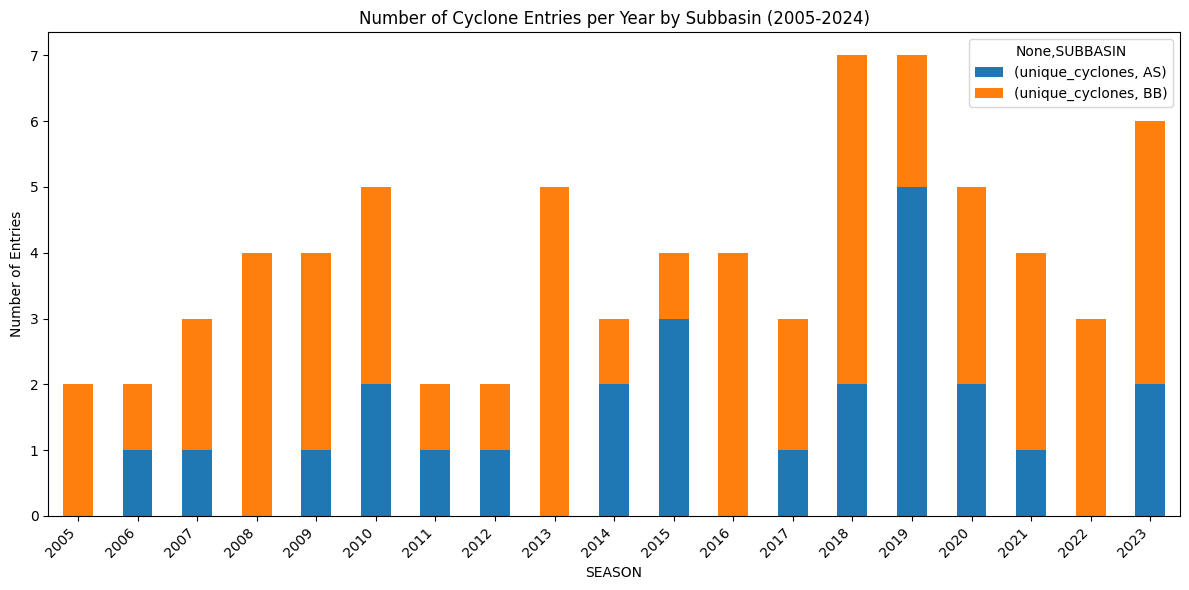

In [ ]:
unique_cyclone_counts = df_2005_named.groupby(['SEASON', 'SUBBASIN'])['NAME'].nunique().reset_index(name='unique_cyclones')
# display(unique_cyclone_counts.head())

pivot_unique_cyclones = unique_cyclone_counts.set_index(['SEASON', 'SUBBASIN']).unstack().fillna(0)
# display(pivot_unique_cyclones.head())

ax = pivot_unique_cyclones.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Cyclone Entries per Year by Subbasin (2005-2024)')
plt.xlabel('SEASON')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot - 2: Visualize the number of cyclones per month.


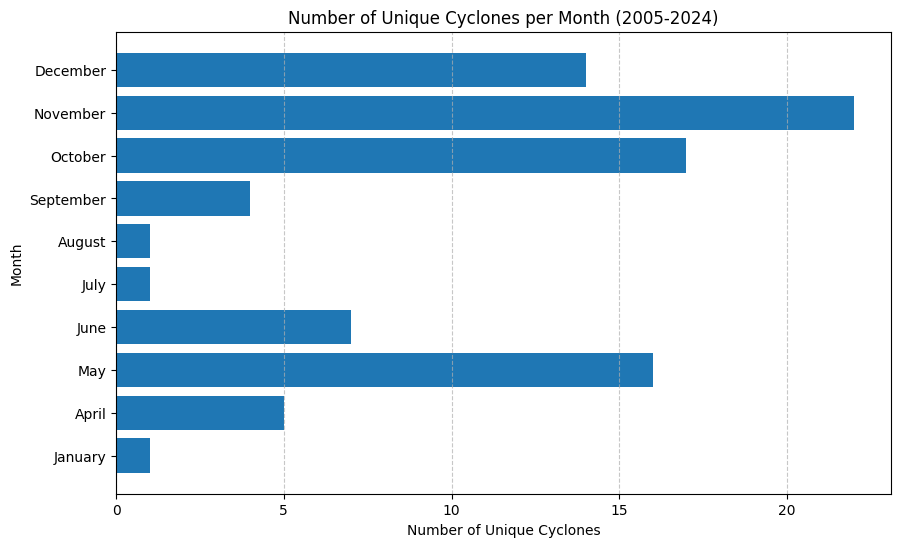

In [ ]:
df_2005_named['ISO_TIME'] = pd.to_datetime(df_2005_named['ISO_TIME'])
df_2005_named['MONTH'] = df_2005_named['ISO_TIME'].dt.month
unique_monthly_cyclones = df_2005_named.groupby('MONTH')['NAME'].nunique().reset_index(name='unique_cyclones')
# display(unique_monthly_cyclones.head())

import calendar

if not unique_monthly_cyclones.empty:
    # Map month numbers to month names
    unique_monthly_cyclones['Month_Name'] = unique_monthly_cyclones['MONTH'].apply(lambda x: calendar.month_name[x])

    # Sort by month number (calendar order)
    unique_monthly_cyclones_calendar_order = unique_monthly_cyclones.sort_values('MONTH')

    plt.figure(figsize=(10, 6))
    plt.barh(unique_monthly_cyclones_calendar_order['Month_Name'], unique_monthly_cyclones_calendar_order['unique_cyclones'])
    plt.title('Number of Unique Cyclones per Month (2005-2024)')
    plt.ylabel('Month')
    plt.xlabel('Number of Unique Cyclones')

    # Ensure month names are displayed in calendar order
    plt.yticks(unique_monthly_cyclones_calendar_order['Month_Name'])
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("The DataFrame unique_monthly_cyclones is empty, so cannot plot the horizontal bar chart.")

# Plot-3: Visualize the cyclone grades per subbasin


In [ ]:
# Find the unique grades for each cyclone
cyclone_grades = df_2005_named.groupby(['SEASON', 'NAME', 'SUBBASIN'])['NEWDELHI_GRADE'].unique().reset_index(name='Unique Grades')

# Define the desired order of grades
grade_order = ['D', 'DD', 'CS', 'SCS', 'VSCS', 'ESCS', 'SUCS']

# Sort the unique grades for each cyclone according to the desired order
cyclone_grades['Unique Grades'] = cyclone_grades['Unique Grades'].apply(lambda x: sorted(x, key=lambda y: grade_order.index(y) if y in grade_order else len(grade_order)))

print("Different grades assigned to each unique cyclone (ordered):")
#display(cyclone_grades)

Different grades assigned to each unique cyclone (ordered):


,SEASON,NAME,SUBBASIN,Unique Grades
0,2005,BAAZ,BB,"[D, DD, CS]"
1,2005,FANOOS,BB,"[D, DD, CS]"
2,2006,MALA,BB,"[D, DD, CS, SCS, VSCS]"
3,2006,MUKDA,AS,"[D, DD, CS, SCS]"
4,2007,AKASH,BB,"[D, DD, CS]"
...,...,...,...,...
70,2023,HAMOON,BB,"[D, DD, CS, SCS, VSCS]"
71,2023,MICHAUNG,BB,"[D, DD, CS, SCS]"
72,2023,MIDHILI,BB,"[D, DD, CS, SCS]"
73,2023,MOCHA,BB,"[D, DD, CS, SCS, VSCS, ESCS]"


In [ ]:
# Extract the last grade from the ordered list for each cyclone
cyclone_grades['Final Grade'] = cyclone_grades['Unique Grades'].apply(lambda x: str(x[-1]))

print("Final grade assigned to each unique cyclone (based on ordered unique grades):")
display(cyclone_grades)

Final grade assigned to each unique cyclone (based on ordered unique grades):


,SEASON,NAME,SUBBASIN,Unique Grades,Final Grade
0,2005,BAAZ,BB,"[D, DD, CS]",CS
1,2005,FANOOS,BB,"[D, DD, CS]",CS
2,2006,MALA,BB,"[D, DD, CS, SCS, VSCS]",VSCS
3,2006,MUKDA,AS,"[D, DD, CS, SCS]",SCS
4,2007,AKASH,BB,"[D, DD, CS]",CS
...,...,...,...,...,...
70,2023,HAMOON,BB,"[D, DD, CS, SCS, VSCS]",VSCS
71,2023,MICHAUNG,BB,"[D, DD, CS, SCS]",SCS
72,2023,MIDHILI,BB,"[D, DD, CS, SCS]",SCS
73,2023,MOCHA,BB,"[D, DD, CS, SCS, VSCS, ESCS]",ESCS


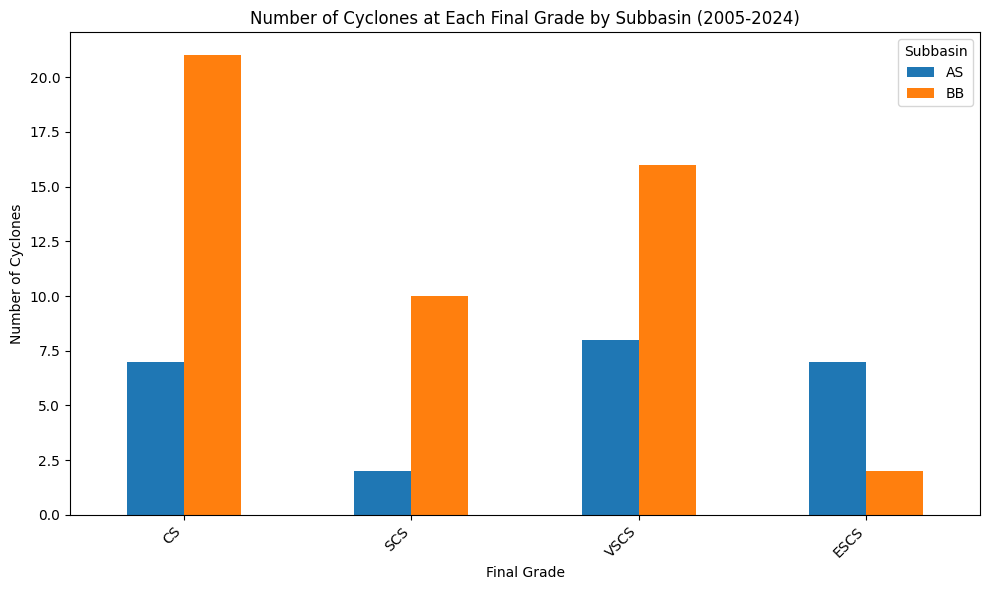

In [ ]:
# Count the number of cyclones at each final grade per subbasin
# Filter out rows where 'Final Grade' is None before counting
final_grade_counts_subbasin = cyclone_grades.dropna(subset=['Final Grade']).groupby('SUBBASIN')['Final Grade'].value_counts().unstack(fill_value=0)

# Define the desired order of grades for plotting
grade_order = ['D', 'DD', 'CS', 'SCS', 'VSCS', 'ESCS', 'SUCS']

# Reindex the columns to ensure the desired order, filling missing grades with 0
final_grade_counts_subbasin = final_grade_counts_subbasin.reindex(columns=grade_order, fill_value=0)

# Remove columns (grades) where the sum of counts across both subbasins is zero
final_grade_counts_subbasin = final_grade_counts_subbasin.loc[:, (final_grade_counts_subbasin.sum(axis=0) != 0)]


# Plotting the clustered bar chart
ax = final_grade_counts_subbasin.T.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Number of Cyclones at Each Final Grade by Subbasin (2005-2024)')
plt.xlabel('Final Grade')
plt.ylabel('Number of Cyclones')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subbasin')
plt.tight_layout()
plt.show()